# E. coli Glycolytic Network Construction
## Growth Medium: Glucose
Growth data obtained from the following sources: 
- Gerosa, Luca et al. “Pseudo-transition Analysis Identifies the Key Regulators of Dynamic Metabolic Adaptations from Steady-State Data.” Cell systems vol. 1,4 (2015): 270-82. doi:10.1016/j.cels.2015.09.008


- Volkmer, Benjamin, and Matthias Heinemann. “Condition-dependent cell volume and concentration of Escherichia coli to facilitate data conversion for systems biology modeling.” PloS one vol. 6,7 (2011): e23126. doi:10.1371/journal.pone.0023126


### Import packages

In [1]:
# Disable gurobi logging output for this notebook.
try:
    import gurobipy
    gurobipy.setParam("OutputFlag", 0)
except ImportError:
    pass


import numpy as np
import pandas as pd
import sympy as sym
import matplotlib.pyplot as plt

import cobra
from cobra.io.json import load_json_model as load_cobra_json_model

import mass
from mass import MassConfiguration, MassModel, MassMetabolite, MassReaction, Simulation
from mass.io.json import save_json_model as save_mass_json_model
from mass.visualization import plot_comparison, plot_time_profile


print(f"COBRApy version: {cobra.__version__}")
print(f"MASSpy version: {mass.__version__}")

Set parameter Username
Academic license - for non-commercial use only - expires 2022-01-21
COBRApy version: 0.22.1
MASSpy version: 0.1.5


### Set solver

In [2]:
MASSCONFIGURATION = MassConfiguration()
MASSCONFIGURATION.solver = "gurobi"

## Load COBRA model

In [3]:
cobra_model = load_cobra_json_model(f"./models/cobra/iML1515.json")

## Obtain Flux State
### Load growth data

In [4]:
medium = "Glucose"

flux_data = pd.read_excel(
    io="./data/growth_data.xlsx",
    sheet_name="flux_data",
    index_col=0
)
flux_data = flux_data.loc[lambda x: x['Growth Medium'] == medium]
flux_data = flux_data.drop("Growth Medium", axis=1)
flux_data

,Flux (mmol * gDW-1 * h-1)
ID,
EX_ac_e,6.827019e+00
ACt2rpp,-6.827019e+00
ACKr,-6.827019e+00
PTAr,6.827019e+00
ACS,0.000000e+00
...,...
ME1,-4.778621e-08
ME2,-4.778621e-08
ICL,9.654038e-10


### Set bounds
#### Growth rate and media

In [5]:
biomass_rxn = cobra_model.reactions.BIOMASS_Ec_iML1515_core_75p37M
growth_rate = flux_data.loc[biomass_rxn.id][0]
biomass_rxn.bounds = (growth_rate, growth_rate)
biomass_rxn.bounds

(0.65, 0.65)

In [6]:
EX_glc__D_e = cobra_model.reactions.EX_glc__D_e
medium_uptake = flux_data.loc[EX_glc__D_e.id][0]
EX_glc__D_e.bounds = (medium_uptake, medium_uptake)
EX_glc__D_e.bounds

(-9.654, -9.654)

### Formulate QP minimization for fluxes

In [7]:
v_vars = []
v_data = []

# For irreversible enzyme pairs, flux data is given as Enzyme1 - Enzyme2 = value.
# To ensure all enzymes have some flux, add a percentage of the net flux for each enzyme
# The netflux will still remain the same value.
reverse_flux_percent = 0.1

irreversible_enzyme_pairs = [["PFK", "FBP"], ["PYK", "PPS"]]


for rid, flux in flux_data.itertuples():
    # Make adjustments to net flux of PFK/FBP and PYK/PPS to ensure
    # no target flux value is 0 in order to create an enzyme module.
    for irreversible_enzyme_pair in irreversible_enzyme_pairs:
        if rid in irreversible_enzyme_pair:
            flux1, flux2 = flux_data.loc[irreversible_enzyme_pair, "Flux (mmol * gDW-1 * h-1)"].values
            if flux1 == 0:
                flux += reverse_flux_percent * flux2 # mmol*gDW^-1*hr^-1
            if flux2 == 0:
                flux += reverse_flux_percent * flux1 # mmol*gDW^-1*hr^-1
            print(rid, flux)
    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)

# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)
F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
cobra_model.objective = objective[0]
cobra_model.objective_direction = "min"

flux_solution = cobra_model.optimize()
flux_solution

PFK 7.76432470140912
FBP 0.7058477001281019
PYK 2.7360389076214697
PPS 0.24873080978377


,fluxes,reduced_costs
CYTDK2,0.000000,0.000000
XPPT,0.000000,0.000000
HXPRT,0.000000,0.045104
NDPK5,0.017561,0.000000
SHK3Dr,0.247727,0.000000
...,...,...
MPTS,0.000000,0.000000
MOCOS,0.000000,0.000000
BMOGDS2,0.000000,0.000000
FESD2s,0.000000,0.000000


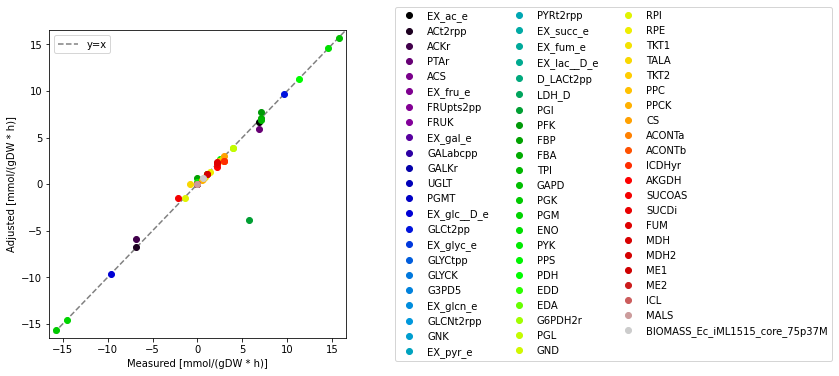

In [8]:
flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_data["Flux (mmol * gDW-1 * h-1)"], y=flux_solution, compare="fluxes",
    observable=[rid for rid in flux_data.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-16.5, 16.5), ylim=(-16.5, 16.5),
    xy_line=True,
    xy_legend="best", xlabel="Measured [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()

#### Export data for analysis

In [9]:
flux_data_for_comparison = pd.concat(objs=(flux_data, flux_solution.fluxes), axis=1).dropna()
flux_data_for_comparison.index.name = "ID"
flux_data_for_comparison.columns = ["Initial", "Adjusted"]
flux_data_for_comparison.to_csv("./data/analysis_data/fluxes.csv")

## Create MASS Model

In [10]:
# Create MassModel
mass_model = MassModel("Glycolysis", array_type="DataFrame")

# Reactions to extract into subnetwork
reaction_list = [
    "PGI", 
    "PFK", 
    "FBP", 
    "FBA", 
    "TPI", 
    "GAPD",
    "PGK", 
    "PGM", 
    "ENO", 
    "PYK", 
    "PPS", 
    "LDH_D",
]


cobra_reactions = cobra_model.reactions.get_by_any(reaction_list)
mass_model.add_reactions([MassReaction(rxn) for rxn in cobra_reactions])
mass_model

Name,Glycolysis
Memory address,0x07ff0d1ebc5b0
Stoichiometric Matrix,19x12
Matrix Rank,12
Number of metabolites,19
Initial conditions defined,0/19
Number of reactions,12
Number of genes,12
Number of enzyme modules,0
Number of groups,0
Objective expression,0


### Convert flux units to M/s

In [11]:
T = 313.15
gas_constant = 0.008314
e_coli_density = 1.1 # g / mL assumption
volume = 3.2  # femtoliter

# Perform conversions
doubling_time_per_minute = np.log(2) / growth_rate * 60
cell_gDW = 42000 * doubling_time_per_minute**-1.232 * 1e-15
real_cell_total_weight = e_coli_density * (volume * 1e-12) # fL --> mL

# Assume water is 70%
adj_volume = volume * 0.7
gDW_L_conversion_factor = real_cell_total_weight / (adj_volume * 1e-15)

for reaction in mass_model.reactions.get_by_any(reaction_list):
    flux = flux_solution[reaction.id]
    reaction.steady_state_flux = flux * gDW_L_conversion_factor * 0.001 / 3600 

## Set equilibrium constants

In [12]:
Keq_data = pd.read_excel(
    io="./data/growth_data.xlsx",
    sheet_name="Keq_data",
    index_col=0
)
for reaction in mass_model.reactions.get_by_any(reaction_list):
    reaction.Keq = Keq_data.loc[reaction.Keq_str][0]

In [13]:
conc_data = pd.read_excel(
    io="./data/growth_data.xlsx",
    sheet_name="conc_data",
    index_col=0
)
conc_data = conc_data.loc[lambda x: x['Growth Medium'] == "Glucose"]
conc_data = conc_data.drop("Growth Medium", axis=1)
conc_data

,Concentration (mol * L-1)
ID,
adp_c,0.002185
amp_c,0.001743
atp_c,0.012466
nad_c,0.007636
nadh_c,0.000099
13dpg_c,0.000184
f6p_c,0.001214
dhap_c,0.004772
g6p_c,0.003431


### Add PFK1 activator GDP

In [14]:
gdp_c = MassMetabolite(cobra_model.metabolites.gdp_c)
# Set the activator as a constant
gdp_c.fixed = True

mass_model.add_metabolites(gdp_c)

### Set initial concentrations from growth data

In [15]:
mass_model.update_initial_conditions({
    mid: value for mid, value in conc_data.itertuples()
})

# Fix hydrogen and water as constants and set concentration to 1.
for metabolite in mass_model.metabolites.get_by_any(["h2o_c", "h_c"]):
    metabolite.fixed = True
    metabolite.initial_condition = 1

missing_ics = mass_model.metabolites.query(lambda m: m.initial_condition is None)
# Provide initial guesses for missing metabolites (pi_c, g3p_c, and lac__D_c)
print(missing_ics)
for metabolite in missing_ics:
    metabolite.initial_condition = 0.001

[<MassMetabolite pi_c at 0x7ff0d1ebcfa0>, <MassMetabolite g3p_c at 0x7ff100dd8280>, <MassMetabolite lac__D_c at 0x7ff100dd8eb0>]


### Formulate QP minimization for concentrations

In [17]:
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)

In [18]:
conc_solver = ConcSolver(
    mass_model,
    excluded_metabolites=["h_c", "h2o_c"],
    constraint_buffer=1,
    equilibrium_reactions=[x.id for x in mass_model.reactions if x.steady_state_flux == 0]

)

conc_solver.setup_feasible_qp_problem(
    fixed_conc_bounds=list(mass_model.fixed),
)

conc_solution = conc_solver.optimize()
conc_solution

,variables,reduced_costs
f6p_c,0.001711,0.0
g6p_c,0.002435,0.0
adp_c,0.002185,0.0
atp_c,0.012466,0.0
fdp_c,0.009390,0.0
...,...,...
Keq_PGM,2.178140,0.0
Keq_ENO,5.190000,0.0
Keq_PYK,21739.130400,0.0
Keq_PPS,2.410000,0.0


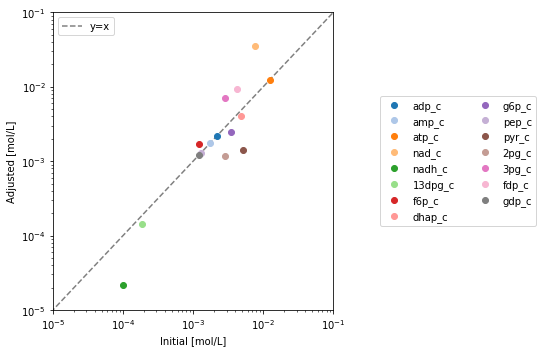

In [19]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_data["Concentration (mol * L-1)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_data.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-5, 1e-1), ylim=(1e-5, 1e-1), xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    mass_model, conc_solution, concentrations=True, Keqs=True, inplace=True);

#### Export data for analysis

In [20]:
conc_data_for_comparison = pd.concat(objs=(conc_data, conc_solution.concentrations), axis=1).dropna()
conc_data_for_comparison.index.name = "ID"
conc_data_for_comparison.columns = ["Initial", "Adjusted"]
conc_data_for_comparison.to_csv("./data/analysis_data/concentrations.csv")
conc_data_for_comparison

,Initial,Adjusted
ID,,
adp_c,0.002185,0.002185
amp_c,0.001743,0.001743
atp_c,0.012466,0.012466
nad_c,0.007636,0.035436
nadh_c,0.000099,0.000021
13dpg_c,0.000184,0.000141
f6p_c,0.001214,0.001711
dhap_c,0.004772,0.004062
g6p_c,0.003431,0.002435


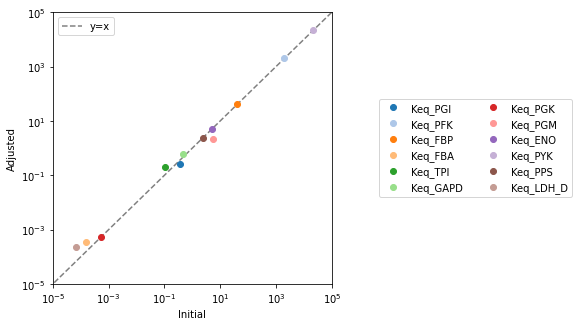

In [21]:
Keq_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

plot_comparison(
    x=Keq_data["Equilibrium Constant"], y=conc_solution,
    compare="Keqs", ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-5, 1e5), ylim=(1e-5, 1e5), xy_line=True,
    xy_legend="best", xlabel="Initial", ylabel="Adjusted")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    mass_model, conc_solution, concentrations=True, Keqs=True, inplace=True);

#### Export data for analysis

In [22]:
Keq_data_for_comparison = pd.concat(objs=(Keq_data, conc_solution.Keqs), axis=1).dropna()
Keq_data_for_comparison.index.name = "ID"
Keq_data_for_comparison.columns = ["Initial", "Adjusted"]
Keq_data_for_comparison.to_csv("./data/analysis_data/equilibrium_constants.csv")
Keq_data_for_comparison

,Initial,Adjusted
ID,,
Keq_PGI,0.364000,0.258394
Keq_PFK,2000.000000,2000.000000
Keq_FBP,41.500000,41.500000
Keq_FBA,0.000160,0.000358
Keq_TPI,0.106952,0.203736
Keq_GAPD,0.452000,0.586631
Keq_PGK,0.000530,0.000530
Keq_PGM,5.300000,2.178140
Keq_ENO,5.190000,5.190000


In [23]:
# Fix Metabolite IDs as SBML compatible before next step
for metabolite in mass_model.metabolites:
    if metabolite.id[0].isdigit():
        metabolite.id = f"_{metabolite.id}"
mass_model.repair()

In [25]:
n_models = 5

In [26]:
conc_solver = ConcSolver(
    mass_model,
    excluded_metabolites=["h_c", "h2o_c"],
    constraint_buffer=1,
    equilibrium_reactions=[x.id for x in mass_model.reactions if x.steady_state_flux == 0]

)

conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(mass_model.fixed),
)
for variable in conc_solver.variables:
    try:
        met = mass_model.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models, seed=4)
conc_samples

,f6p_c,g6p_c,adp_c,atp_c,fdp_c,pi_c,dhap_c,g3p_c,_13dpg_c,nad_c,nadh_c,_3pg_c,_2pg_c,pep_c,pyr_c,amp_c,lac__D_c,gdp_c
0,0.010470,0.010661,0.013486,0.105633,0.024770,0.004267,0.005646,0.000339,0.000149,0.073327,0.000050,0.011918,0.001586,0.001170,0.000168,0.000468,0.000491,0.000121
1,0.000553,0.000743,0.003268,0.001477,0.005574,0.004123,0.002493,0.000171,0.000108,0.112689,0.000071,0.038825,0.005840,0.002756,0.001839,0.008645,0.004783,0.000456
2,0.003326,0.004251,0.003567,0.001996,0.011121,0.011735,0.003586,0.000109,0.000027,0.147767,0.000113,0.019942,0.000497,0.000485,0.000204,0.004712,0.000692,0.000146
3,0.001739,0.002718,0.009105,0.001749,0.002127,0.008857,0.002809,0.000071,0.000029,0.043257,0.000055,0.038715,0.000583,0.000700,0.000203,0.002591,0.001066,0.000122
4,0.001519,0.001621,0.004541,0.002020,0.003339,0.012093,0.000720,0.000049,0.000028,0.033218,0.000030,0.028609,0.000541,0.000468,0.000170,0.001633,0.000637,0.000121


### Balance network with pseudoreactions and calculate PERCs

In [27]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = mass_model.copy()
    new_model.id += "_C{0:d}".format(idx)
    print(f"Creating model {new_model.id}")
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)
    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0:
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)

        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)

        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        try:
            # Update PERCs
            new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not r.boundary},
                update_reactions=True)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            continue
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(
    len(models_for_ensemble)))

Creating model Glycolysis_C0
Creating model Glycolysis_C1
Creating model Glycolysis_C2
Creating model Glycolysis_C3
Creating model Glycolysis_C4
Number of models in ensemble: 5


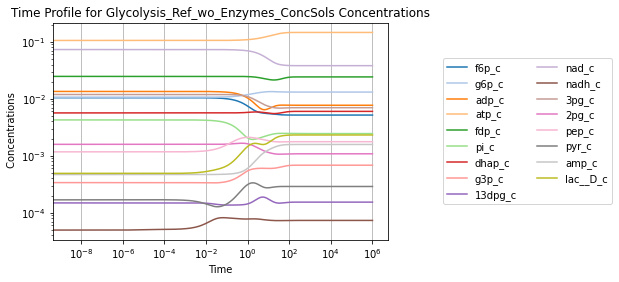

In [28]:
reference_model = models_for_ensemble[0].copy()
reference_model.id = "Glycolysis_Ref_wo_Enzymes"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol, flux_sol = sim.simulate(reference_model, time=(0, tfinal))
conc_sol.view_time_profile()


#### Save a reference MASS model w/o enzymes

In [29]:
conc_sol, flux_sol = sim.find_steady_state(
    models=reference_model, strategy="simulate", 
    tfinal=tfinal)
if conc_sol and flux_sol:
    reference_model.update_initial_conditions(conc_sol)
    reference_model.update_parameters({f"v_{k}": v for k, v in flux_sol.items()})
    # Save a reference MASS model
    save_mass_json_model(
        mass_model=reference_model,
        filename=f"./models/mass/without_enzymes/{reference_model.id}.json")
    print(f"Saving {reference_model.id}")
reference_model

Saving Glycolysis_Ref_wo_Enzymes


Name,Glycolysis_Ref_wo_Enzymes
Memory address,0x07ff0f115da30
Stoichiometric Matrix,20x27
Matrix Rank,19
Number of metabolites,20
Initial conditions defined,20/20
Number of reactions,27
Number of genes,12
Number of enzyme modules,0
Number of groups,0
Objective expression,0


## Create Enzyme Modules

Assume 90% of flux goes through the major isozyme, the remaining through the minor isozyme

In [30]:
from construction_functions import make_enzyme_module_from_dir

In [31]:
isozyme1_percent = 0.9
isozyme2_percent = 0.1

# Isozymes and flux split percentages,
isozymes_and_flux_splits = {
    "PFK": {
        "PFK1": isozyme1_percent,
        "PFK2": isozyme2_percent,
    },
    "FBP": {
        "FBP1": isozyme1_percent,
        "FBP2": isozyme2_percent,
    },
    "FBA": {
        "FBA1": isozyme1_percent,
        "FBA2": isozyme2_percent,
    },
    "PGM": {
        "PGMi": isozyme1_percent,
        "PGMd": isozyme2_percent,
    },
    "PYK": {
        "PYK1": isozyme1_percent,
        "PYK2": isozyme2_percent,
    },
}
        
isozymes_and_flux_splits

{'PFK': {'PFK1': 0.9, 'PFK2': 0.1},
 'FBP': {'FBP1': 0.9, 'FBP2': 0.1},
 'FBA': {'FBA1': 0.9, 'FBA2': 0.1},
 'PGM': {'PGMi': 0.9, 'PGMd': 0.1},
 'PYK': {'PYK1': 0.9, 'PYK2': 0.1}}

In [32]:
final_ensemble = []
for model in models_for_ensemble:
    enzyme_modules = {}
    for reaction in model.reactions.get_by_any(reaction_list):
        # PGM & PGK needs flux flipped since enzyme module stoichiometry
        # is reversed compared to lone reaction.
        if reaction.id in ["PGK", "PGM"]:
            flux = -reaction.steady_state_flux
        else:
            flux = reaction.steady_state_flux
        # Make isozymes
        if reaction.id in isozymes_and_flux_splits:
            isozymes_and_flux_split = isozymes_and_flux_splits[reaction.id]
            isozyme_modules = []
            for isozyme, flux_split in isozymes_and_flux_split.items():
                enzyme_module = make_enzyme_module_from_dir(
                    enzyme_id=isozyme,
                    steady_state_flux=flux * flux_split, # Split flux for isozymes
                    metabolite_concentrations=model.initial_conditions,
                    path_to_dir="./data/enzyme_module_data",
                    kcluster=1,
                    enzyme_gpr=reaction.gene_reaction_rule,
                    zero_tol=1e-10)
                isozyme_modules += [enzyme_module]
            enzyme_modules[reaction] = isozyme_modules
        else:
            enzyme_module = make_enzyme_module_from_dir(
                enzyme_id=reaction.id,
                steady_state_flux=flux,
                metabolite_concentrations=new_model.initial_conditions,
                path_to_dir="./data/enzyme_module_data",
                kcluster=1,
                enzyme_gpr=reaction.gene_reaction_rule,
                zero_tol=1e-10)
            enzyme_modules[reaction] = [enzyme_module]
    for reaction_to_remove, enzymes_to_add in enzyme_modules.items():
        model.remove_reactions([reaction_to_remove])
        for enzyme in enzymes_to_add:
            model = model.merge(enzyme, inplace=True)
    final_ensemble += [model]
    print(f"Finished {model.id}")

Finished Glycolysis_C0
Finished Glycolysis_C1
Finished Glycolysis_C2
Finished Glycolysis_C3
Finished Glycolysis_C4


# Inspect a model

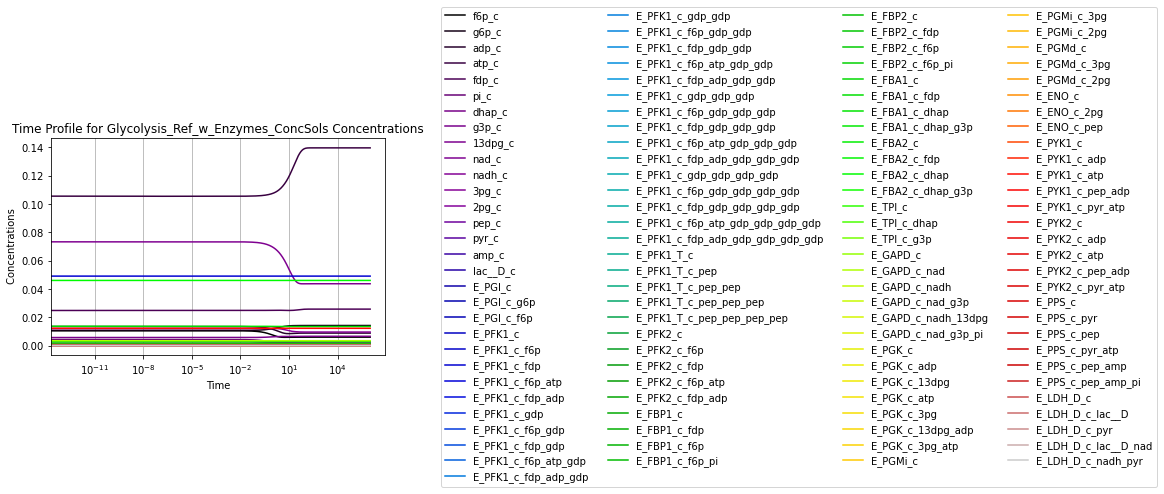

In [33]:
reference_model = models_for_ensemble[0].copy()
reference_model.id = "Glycolysis_Ref_w_Enzymes"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol, flux_sol = sim.simulate(reference_model, time=(0, tfinal))
conc_sol.view_time_profile(plot_function="semilogx")


#### Save a reference MASS model w/ enzymes

In [34]:
conc_sol, flux_sol = sim.find_steady_state(
    models=reference_model, strategy="simulate", update_values=True,
    tfinal=tfinal)
if conc_sol and flux_sol:
    # Save a reference MASS model
    save_mass_json_model(
        mass_model=reference_model,
        filename=f"./models/mass/with_enzymes/{reference_model.id}.json")
    print(f"Saving {reference_model.id}")
reference_model

Saving Glycolysis_Ref_w_Enzymes


Name,Glycolysis_Ref_w_Enzymes
Memory address,0x07ff0c1f03880
Stoichiometric Matrix,120x121
Matrix Rank,102
Number of metabolites,120
Initial conditions defined,120/120
Number of reactions,121
Number of genes,19
Number of enzyme modules,17
Number of groups,0
Objective expression,0


## Simulate to steady state and export ensemble

In [35]:
sim = Simulation(final_ensemble[0])
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9
sim.integrator.
sim.add_models(final_ensemble[1:], disable_safe_load=True)
for model in final_ensemble:
    # Attempt to determine steady state
    conc_sol, flux_sol = sim.find_steady_state(
        models=model, strategy="simulate", update_values=True,
        tfinal=tfinal)
    if conc_sol and flux_sol:
        # Save a reference MASS model
        save_mass_json_model(
            mass_model=model,
            filename=f"./models/mass/with_enzymes/{model.id}.json")
        print(f"Saving {model.id}")
    else:
        print(f"No steady state for {model.id}.")

Saving Glycolysis_C0
Saving Glycolysis_C1
Saving Glycolysis_C2
Saving Glycolysis_C3
Saving Glycolysis_C4
